# Data Analytics project - prediction of electric current prices

### Libraries

In [3]:
import datetime
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import time
from typing import List

from cmdstanpy import CmdStanModel
from sklearn.metrics import mean_squared_error
import seaborn as sns

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importing data

#### Data 2019

In [4]:
df_ceny: pd.DataFrame = pd.read_csv("../Data/Prices/PL_CENY_NIEZB_RB_20190301_20190331.csv", sep=";", decimal=",")
df_zapotrzebowanie: pd.DataFrame = pd.read_csv("../Data/Load/PL_WYK_KSE_20190301_20190331.csv", encoding="cp1250", sep=";", decimal=",")
df_ceny["Data_i_Godzina"] = df_ceny["Data"].astype(str) + " " + (df_ceny["Godzina"] - 1).astype(str)  # Hours 1-24, changed into 0-23
df_ceny["Data_i_Godzina"] = df_ceny["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y%m%d %H",))
df_ceny = df_ceny[["Data", "Godzina", "Data_i_Godzina", "CRO"]]
df_zapotrzebowanie["Data_i_Godzina"] = df_zapotrzebowanie["Data"].astype(str) + " " + (df_zapotrzebowanie["Godzina"] - 1).astype(str) # Hours 1-24, changed into 0-23
df_zapotrzebowanie["Data_i_Godzina"] = df_zapotrzebowanie["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y-%m-%d %H",))
df_zapotrzebowanie["Dzień tygodnia"] = df_zapotrzebowanie["Data"].astype(str).apply(lambda x: pd.Timestamp(x).day_of_week)
df_list: List[pd.DataFrame] = []
df_naslonecznienie_temp: pd.DataFrame
for file in os.listdir("../Data/Weather2019"):
    df_naslonecznienie_temp = pd.read_csv(f"../Data/Weather2019/{file}", header=6, skipfooter=11, engine="python")
    df_naslonecznienie_temp = df_naslonecznienie_temp.loc[:, ["time", "G(i)", "T2m", "WS10m"]]
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(str.__getitem__, args=(slice(None, -2, None),))
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(datetime.datetime.strptime, args=("%Y%m%d:%H",))
    df_list.append(df_naslonecznienie_temp)
df_naslonecznienie: pd.DataFrame = pd.concat(df_list)
df_naslonecznienie = df_naslonecznienie.groupby("time").mean().reset_index()
df_naslonecznienie_marzec = df_naslonecznienie.loc[
    df_naslonecznienie["time"].between(datetime.datetime(2019, 3, 1), datetime.datetime(2019, 4, 1), inclusive="left")
    ]
df_naslonecznienie_marzec.reset_index(inplace=True)


#### Data 2020

In [5]:
df_ceny2020: pd.DataFrame = pd.read_csv("../Data/Prices/PL_CENY_NIEZB_RB_20200301_20200331.csv", sep=";", decimal=",")
df_zapotrzebowanie2020: pd.DataFrame = pd.read_csv("../Data/Load/PL_WYK_KSE_20200301_20200331.csv", encoding="cp1250", sep=";", decimal=",")
df_ceny2020["Data_i_Godzina"] = df_ceny2020["Data"].astype(str) + " " + (df_ceny2020["Godzina"] - 1).astype(str)  # Hours 1-24, changed into 0-23
df_ceny2020["Data_i_Godzina"] = df_ceny2020["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y%m%d %H",))
df_ceny2020 = df_ceny2020[["Data", "Godzina", "Data_i_Godzina", "CRO"]]
df_zapotrzebowanie2020["Data_i_Godzina"] = df_zapotrzebowanie2020["Data"].astype(str) + " " + (df_zapotrzebowanie2020["Godzina"] - 1).astype(str) # Hours 1-24, changed into 0-23
df_zapotrzebowanie2020["Data_i_Godzina"] = df_zapotrzebowanie2020["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y-%m-%d %H",))
df_zapotrzebowanie2020["Dzień tygodnia"] = df_zapotrzebowanie2020["Data"].astype(str).apply(lambda x: pd.Timestamp(x).day_of_week)
df_list2020: List[pd.DataFrame] = []
df_naslonecznienie_temp: pd.DataFrame
for file in os.listdir("../Data/Weather2020"):
    df_naslonecznienie_temp = pd.read_csv(f"../Data/Weather2020/{file}", header=6, skipfooter=11, engine="python")
    df_naslonecznienie_temp = df_naslonecznienie_temp.loc[:, ["time", "Gb(i)", "Gd(i)", "Gr(i)", "T2m", "WS10m"]]
    df_naslonecznienie_temp["G(i)"] = df_naslonecznienie_temp[["Gb(i)", "Gd(i)", "Gr(i)"]].sum(axis=1)
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(str.__getitem__, args=(slice(None, -2, None),))
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(datetime.datetime.strptime, args=("%Y%m%d:%H",))
    df_list2020.append(df_naslonecznienie_temp)
df_naslonecznienie2020: pd.DataFrame = pd.concat(df_list2020)
df_naslonecznienie2020 = df_naslonecznienie2020.groupby("time").mean().reset_index()
df_naslonecznienie_marzec2020 = df_naslonecznienie2020.loc[
    df_naslonecznienie2020["time"].between(datetime.datetime(2020, 3, 1), datetime.datetime(2020, 4, 1), inclusive="left")
    ]
df_naslonecznienie_marzec2020.reset_index(inplace=True)

## Demand

### Quadratic regression for prior

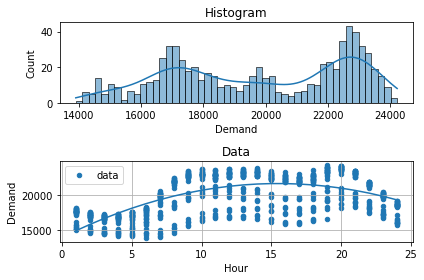

[-31.699156569241612, 980.9577410368405, 13984.774370230132]


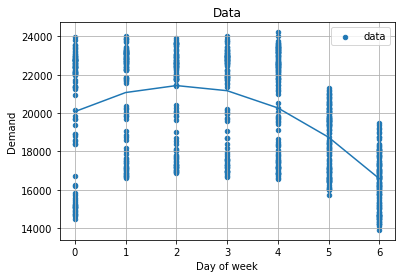

[-315.4445914817592, 1309.6339866197832, 20080.934521750652]


In [6]:
data = df_zapotrzebowanie[["Godzina", "Krajowe zapotrzebowanie na moc", "Dzień tygodnia"]]
ax = plt.subplot(2, 1, 1)
sns.histplot(data["Krajowe zapotrzebowanie na moc"], kde=True, ax=ax, bins=50)
plt.xlabel("Demand")
plt.title(f"Histogram")
x = data["Godzina"]
ax = plt.subplot(2, 1, 2)
data.plot(x="Godzina", y="Krajowe zapotrzebowanie na moc", kind="scatter", grid=True, label="data", ax=ax)
plt.title(f"Data")
plt.ylabel("Demand")
plt.xlabel("Hour")
coef = np.polyfit(x, data["Krajowe zapotrzebowanie na moc"], 2)  # Degree
p = np.poly1d(coef)
x = np.sort(x.drop_duplicates().to_numpy())
ax.plot(x, p(x), label="regression")
plt.tight_layout()
plt.show()
print(coef.tolist())
x = data["Dzień tygodnia"]
data.plot(x="Dzień tygodnia", y="Krajowe zapotrzebowanie na moc", kind="scatter", grid=True, label="data")
plt.title(f"Data")
plt.ylabel("Demand")
plt.xlabel("Day of week")
coef = np.polyfit(x, data["Krajowe zapotrzebowanie na moc"], 2)  # Degree
p = np.poly1d(coef)
x = np.sort(x.drop_duplicates().to_numpy())
plt.plot(x, p(x), label="regression")
plt.show()
print(coef.tolist())

### Prior

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing


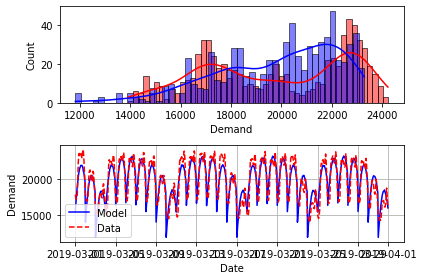

RMSE = 1352.1623569766198 / (max possible) 19982.844134824838


In [7]:
demand_ppc=CmdStanModel(stan_file='demand_ppc.stan')
demand = demand_ppc.sample(show_progress=False, data=dict(
    N=len(df_zapotrzebowanie), day_of_week=df_zapotrzebowanie["Dzień tygodnia"].values, 
    hour=df_zapotrzebowanie["Godzina"].values
    ))
df_demand = demand.draws_pd()
df_demand_mean = df_demand.mean()[[f"demand[{i}]" for i in range(1, len(df_zapotrzebowanie) + 1)]]
y_true = df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"]

ax = plt.subplot(2, 1, 1)
sns.histplot(y_true, kde=True, ax=ax, bins=50, color="r")
plt.xlabel("Demand")
sns.histplot(df_demand_mean, kde=True, ax=ax, bins=50, color="b")
plt.xlabel("Demand")
ax = plt.subplot(2, 1, 2)
ax.plot(df_zapotrzebowanie["Data_i_Godzina"], df_demand_mean, "b-",
         df_zapotrzebowanie["Data_i_Godzina"], y_true, "r--",)
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, df_demand_mean.values, squared=False)} / (max possible) '
      f'{mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')

                Mean    MCSE  StdDev       5%      50%      95%   N_Eff  \
name                                                                      
lp__             0.0     NaN     0.0      0.0      0.0      0.0     NaN   
a_hour         -32.0    0.16    10.0    -49.0    -32.0    -15.0  3900.0   
b_hour         980.0    0.16     9.9    960.0    980.0   1000.0  3800.0   
offset_      14000.0   34.00  2100.0  11000.0  14000.0  18000.0  3700.0   
a_day         -300.0    0.32    20.0   -330.0   -300.0   -270.0  3900.0   
...              ...     ...     ...      ...      ...      ...     ...   
demand[739]  17610.0   71.00  4548.0   9957.0  17592.0  25050.0  4078.0   
demand[740]  17352.0   78.00  4918.0   9178.0  17373.0  25440.0  3948.0   
demand[741]  16943.0   86.00  5362.0   8049.0  16854.0  25910.0  3892.0   
demand[742]  16573.0   91.00  5657.0   7243.0  16534.0  25854.0  3835.0   
demand[743]  15975.0  101.00  6163.0   5780.0  15886.0  25964.0  3701.0   

             N_Eff/s  R_

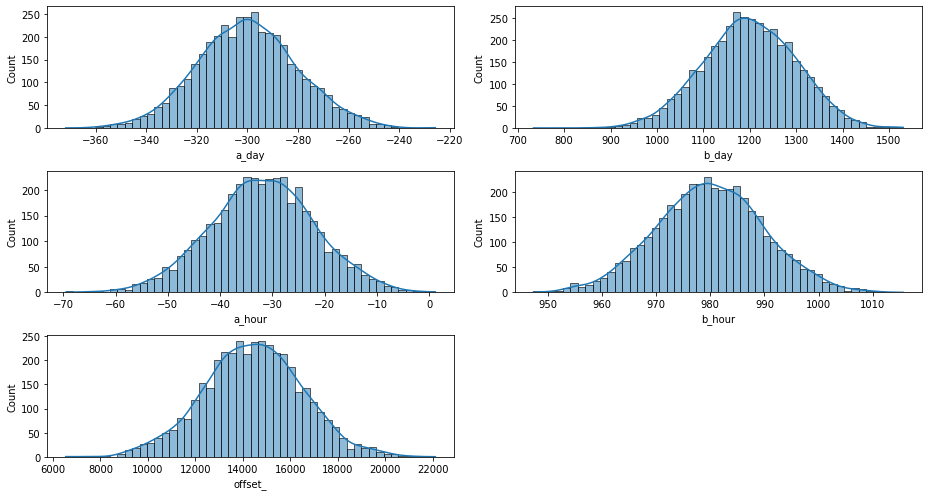

In [10]:
print(demand.summary())
parameters = ["a_day", "b_day", "a_hour", "b_hour", "offset_"]
N = len(parameters)
plt.figure(figsize=(13, 7))
for i in range(N):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df_demand[parameters[i]], bins=50, kde=True)
plt.tight_layout()
plt.show()

### Posterior

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


Processing csv files: /tmp/tmp8ussj4k9/demand_posterior-20230711112645_1.csv, /tmp/tmp8ussj4k9/demand_posterior-20230711112645_2.csv, /tmp/tmp8ussj4k9/demand_posterior-20230711112645_3.csv, /tmp/tmp8ussj4k9/demand_posterior-20230711112645_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.01, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  offset_, a_day, b_day, demand[1], demand[2], demand[3], demand[4], demand[5], demand[6], demand[7], demand[8], demand[9], demand[10], demand[11], demand[12], demand[13], demand[14], demand[15], demand[16], demand[17], demand[18], demand[19], demand[20

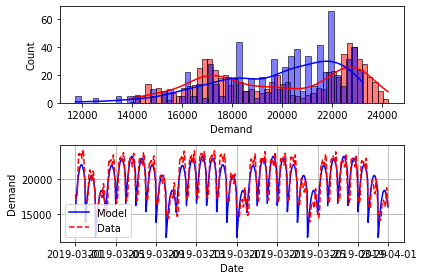

RMSE = 1349.3308917735706 / (max possible) 19982.844134824838


In [11]:
demand_posterior=CmdStanModel(stan_file='demand_posterior.stan')
demand_post = demand_posterior.sample(show_progress=False, data=dict(
    N=len(df_zapotrzebowanie), day_of_week=df_zapotrzebowanie["Dzień tygodnia"].values, hour=df_zapotrzebowanie["Godzina"].values, 
    demand_samples=df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].values
    ))
print(demand_post.diagnose())
df_demand_post = demand_post.draws_pd()
df_demand_post_mean = df_demand_post.mean()[[f"demand[{i}]" for i in range(1, len(df_zapotrzebowanie) + 1)]]
y_true = df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"]

ax = plt.subplot(2, 1, 1)
sns.histplot(y_true, kde=True, ax=ax, bins=50, color="r")
plt.xlabel("Demand")
sns.histplot(df_demand_post_mean, kde=True, ax=ax, bins=50, color="b")
plt.xlabel("Demand")
ax = plt.subplot(2, 1, 2)
ax.plot(df_zapotrzebowanie["Data_i_Godzina"], df_demand_post_mean, "b-",
         df_zapotrzebowanie["Data_i_Godzina"], y_true, "r--",)
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, df_demand_post_mean.values, squared=False)} / (max possible) '
      f'{mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')

### Temperature's influence on the load

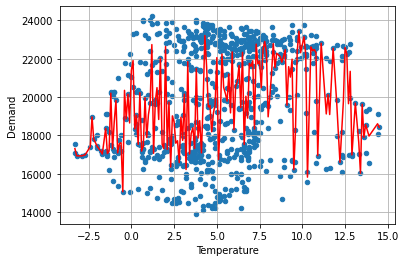

In [12]:
data = df_zapotrzebowanie[["Data_i_Godzina", "Godzina", "Krajowe zapotrzebowanie na moc"]]
# data = data[data["Godzina"].between(11, 21)]
data.insert(len(data.columns), "Temperatura", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["T2m"].values[0], 1) for i in range(len(data))
    ])
data.plot(x="Temperatura", y="Krajowe zapotrzebowanie na moc", kind="scatter", grid=True)
plt.plot(sorted(data["Temperatura"].unique()), data.groupby(["Temperatura"], sort=True).median()["Krajowe zapotrzebowanie na moc"], "r-")
plt.xlabel("Temperature")
plt.ylabel("Demand")
plt.show()

It seems that there is no influence of temperature on the demand, contrary to the project's assumptions.

## Generation

### Quadratic (wind speed) and linear (irradiance) regression

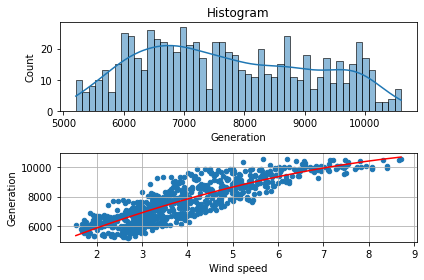

[ -56.4494838  1323.95434066 3449.06592958]


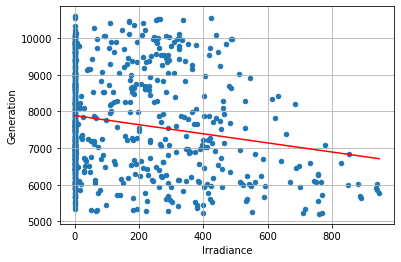

[-1.24182856e+00  7.88788242e+03]


In [13]:
data = df_zapotrzebowanie[["Data_i_Godzina", "Sumaryczna generacja nJWCD"]]
data.insert(len(data.columns), "Irradiance", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["G(i)"].values[0], 0) for i in range(len(data))
    ])
data.insert(len(data.columns), "Wind speed", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["WS10m"].values[0], 2) for i in range(len(data))
    ])
ax = plt.subplot(2, 1, 1)
sns.histplot(data["Sumaryczna generacja nJWCD"], kde=True, ax=ax, bins=50)
plt.xlabel("Generation")
plt.title(f"Histogram")
ax = plt.subplot(2, 1, 2)
x = data["Wind speed"]
data.plot(x="Wind speed", y="Sumaryczna generacja nJWCD", kind="scatter", grid=True, ax=ax)
coef_generation = np.polyfit(x, data["Sumaryczna generacja nJWCD"], 2)  # Degree
p = np.poly1d(coef_generation)
x = np.sort(x.drop_duplicates().to_numpy())
ax.plot(x, p(x), "r-")
plt.ylabel("Generation")
plt.tight_layout()
plt.show()
print(coef_generation)
x = data["Irradiance"]
data.plot(x="Irradiance", y="Sumaryczna generacja nJWCD", kind="scatter", grid=True)
coef_generation = np.polyfit(x, data["Sumaryczna generacja nJWCD"], 1)  # Degree
p = np.poly1d(coef_generation)
x = np.sort(x.drop_duplicates().to_numpy())
plt.plot(x, p(x), "r-")
plt.ylabel("Generation")
plt.show()
print(coef_generation)

### Prior

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


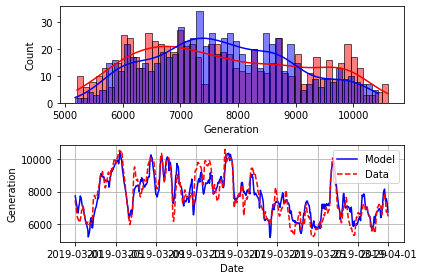

RMSE = 579.2129207151688 / (max possible) 7836.455433017564


In [14]:
generation_ppc=CmdStanModel(stan_file='generation_ppc.stan')
generation = generation_ppc.sample(show_progress=False, data=dict(
    N=len(data), wind_speed=data["Wind speed"].values, irradiance=data["Irradiance"].values
    ))
df_generation = generation.draws_pd()
df_generation_mean = df_generation.mean()[[f"generation[{i}]" for i in range(1, len(data) + 1)]]
y_true = data["Sumaryczna generacja nJWCD"]

ax = plt.subplot(2, 1, 1)
sns.histplot(y_true, kde=True, ax=ax, bins=50, color="r")
plt.xlabel("Generation")
sns.histplot(df_generation_mean, kde=True, ax=ax, bins=50, color="b")
plt.xlabel("Generation")
ax = plt.subplot(2, 1, 2)
ax.plot(data["Data_i_Godzina"], df_generation_mean, "b-",
        data["Data_i_Godzina"], y_true, "r--",)
plt.xlabel("Date")
plt.ylabel("Generation")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, df_generation_mean.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')

                   Mean     MCSE  StdDev      5%     50%     95%   N_Eff  \
name                                                                       
lp__                0.0      NaN     0.0     0.0     0.0     0.0     NaN   
a_ws              -60.0   0.1500     9.9   -77.0   -60.0   -44.0  4100.0   
b_ws             1400.0   1.6000   100.0  1200.0  1400.0  1500.0  4000.0   
a_irr              -1.4   0.0016     0.1    -1.6    -1.4    -1.2  4000.0   
offset_          3600.0   8.3000   500.0  2800.0  3600.0  4400.0  3700.0   
...                 ...      ...     ...     ...     ...     ...     ...   
generation[739]  7565.0  19.0000  1181.0  5614.0  7562.0  9530.0  3984.0   
generation[740]  7455.0  19.0000  1193.0  5485.0  7458.0  9437.0  3828.0   
generation[741]  7315.0  18.0000  1157.0  5430.0  7311.0  9198.0  3931.0   
generation[742]  7033.0  18.0000  1147.0  5112.0  7026.0  8933.0  4074.0   
generation[743]  6736.0  19.0000  1158.0  4817.0  6735.0  8651.0  3832.0   

           

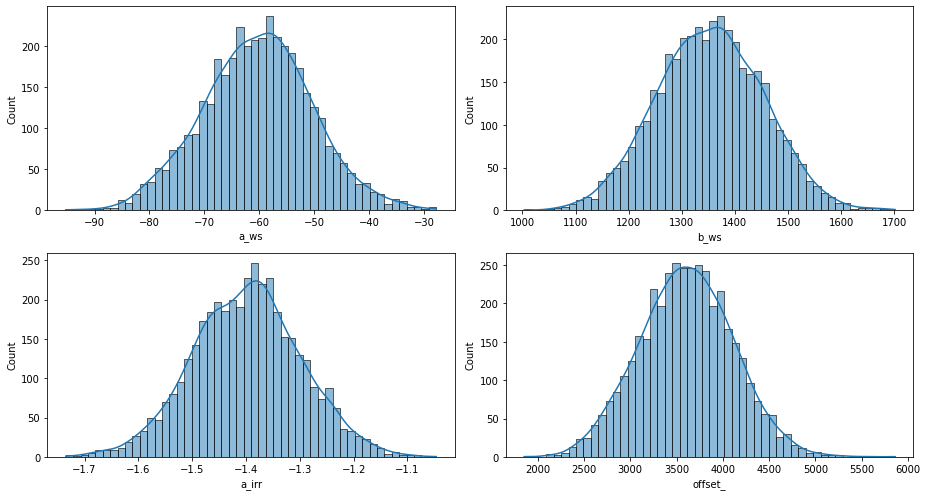

In [16]:
print(generation.summary())
parameters = ["a_ws", "b_ws", "a_irr", "offset_"]
N = len(parameters)
plt.figure(figsize=(13, 7))
for i in range(N):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_generation[parameters[i]], bins=50, kde=True)
plt.tight_layout()
plt.show()

### Posterior

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing


Processing csv files: /tmp/tmp8ussj4k9/generation_posterior-20230711120215_1.csv, /tmp/tmp8ussj4k9/generation_posterior-20230711120215_2.csv, /tmp/tmp8ussj4k9/generation_posterior-20230711120215_3.csv, /tmp/tmp8ussj4k9/generation_posterior-20230711120215_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



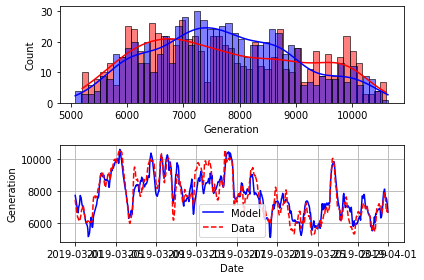

RMSE = 569.5639555407419 / (max possible) 7836.455433017564


In [19]:
y_true = data["Sumaryczna generacja nJWCD"]
generation_posterior=CmdStanModel(stan_file='generation_posterior.stan')
generation_post = generation_posterior.sample(show_progress=False, data=dict(
    N=len(data), wind_speed=data["Wind speed"].values, irradiance=data["Irradiance"].values, 
    generation_samples=y_true.values
    ))
print(generation_post.diagnose())
# print(generation_post.summary())
df_generation_post = generation_post.draws_pd()
df_generation_post_mean = df_generation_post.mean()[[f"generation[{i}]" for i in range(1, len(y_true) + 1)]]

ax = plt.subplot(2, 1, 1)
sns.histplot(y_true, kde=True, ax=ax, bins=50, color="r")
plt.xlabel("Generation")
sns.histplot(df_generation_post_mean, kde=True, ax=ax, bins=50, color="b")
plt.xlabel("Generation")
ax = plt.subplot(2, 1, 2)
ax.plot(data["Data_i_Godzina"], df_generation_post_mean, "b-",
         data["Data_i_Godzina"], y_true, "r--",)
plt.xlabel("Date")
plt.ylabel("Generation")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, df_generation_post_mean.values, squared=False)} / (max possible) '
      f'{mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')

## Prices

### Determining the relation with Load and generation

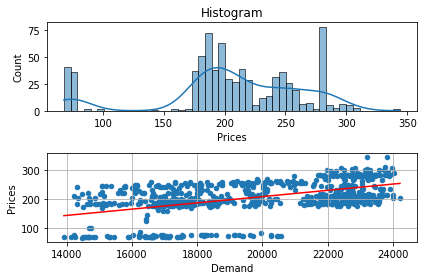

Coef demand [ 0.01070359 -5.34409143]
Coef generation [-7.16163456e-03  2.61603290e+02]


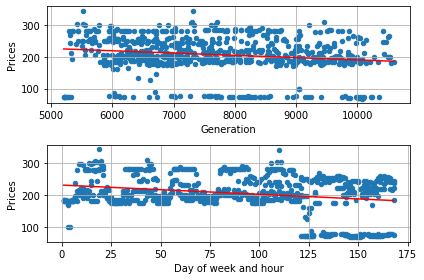

Coef time [ -0.2900096  232.20536388]


In [20]:
data = df_zapotrzebowanie.loc[:, ["Data_i_Godzina", "Sumaryczna generacja nJWCD", "Krajowe zapotrzebowanie na moc", "Godzina", "Dzień tygodnia"]]
data["Day_of_week_hour"] = data["Dzień tygodnia"] * 24 + data["Godzina"]
data.insert(len(data.columns), "Prices", [
    df_ceny.loc[df_ceny["Data_i_Godzina"] == data.iloc[i]["Data_i_Godzina"]]["CRO"].values[0] for i in range(len(data))
    ])
data["Residual load"] = data["Krajowe zapotrzebowanie na moc"] - data["Sumaryczna generacja nJWCD"]
ax = plt.subplot(2, 1, 1)
sns.histplot(data["Prices"], kde=True, ax=ax, bins=50)
plt.xlabel("Prices")
plt.title(f"Histogram")
ax = plt.subplot(2, 1, 2)
x = data["Krajowe zapotrzebowanie na moc"]
data.plot(x="Krajowe zapotrzebowanie na moc", y="Prices", kind="scatter", grid=True, ax=ax)
coef = np.polyfit(x, data["Prices"], 1)  # Degree
p = np.poly1d(coef)
x = np.sort(x.drop_duplicates().to_numpy())
ax.plot(x, p(x), "r-")
plt.ylabel("Prices")
plt.xlabel("Demand")
plt.tight_layout()
plt.show()
print(f"Coef demand {coef}")
ax = plt.subplot(2, 1, 1)
x = data["Sumaryczna generacja nJWCD"]
data.plot(x="Sumaryczna generacja nJWCD", y="Prices", kind="scatter", grid=True, ax=ax)
coef = np.polyfit(x, data["Prices"], 1)  # Degree
p = np.poly1d(coef)
x = np.sort(x.drop_duplicates().to_numpy())
ax.plot(x, p(x), "r-")
plt.ylabel("Prices")
plt.xlabel("Generation")
print(f"Coef generation {coef}")
ax = plt.subplot(2, 1, 2)
x = data["Day_of_week_hour"]
data.plot(x="Day_of_week_hour", y="Prices", kind="scatter", grid=True, ax=ax)
coef = np.polyfit(x, data["Prices"], 1)  # Degree
p = np.poly1d(coef)
x = np.sort(x.drop_duplicates().to_numpy())
ax.plot(x, p(x), "r-")
plt.ylabel("Prices")
plt.xlabel("Day of week and hour")
plt.tight_layout()
plt.show()
print(f"Coef time {coef}")

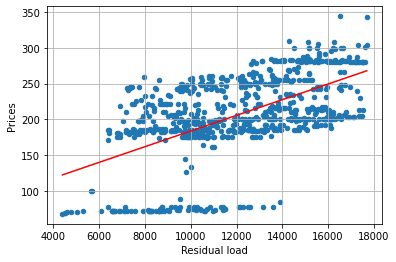

[1.09332625e-02 7.44274576e+01]


In [21]:
x = data["Residual load"]
data.plot(x="Residual load", y="Prices", kind="scatter", grid=True)
coef_prices = np.polyfit(x, data["Prices"], 1)  # Degree
p = np.poly1d(coef_prices)
x = np.sort(x.drop_duplicates().to_numpy())
plt.plot(x, p(x), "r-")
plt.show()
print(coef_prices)

### Prior

INFO:cmdstanpy:compiling stan file /home/ProjektDataAnalytics/Model_2_Fitting_to_histograms_with_irradiance/prices_ppc.stan to exe file /home/ProjektDataAnalytics/Model_2_Fitting_to_histograms_with_irradiance/prices_ppc
INFO:cmdstanpy:compiled model executable: /home/ProjektDataAnalytics/Model_2_Fitting_to_histograms_with_irradiance/prices_ppc
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing


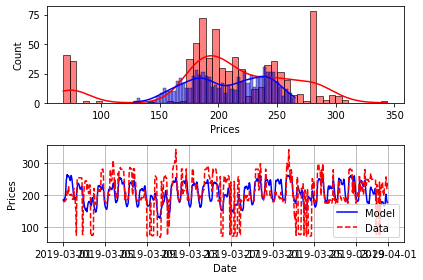

RMSE = 48.13380528106451 / (max possible) 214.47741087247994


In [22]:
y_true = data["Prices"]
prices_ppc=CmdStanModel(stan_file='prices_ppc.stan')
prices = prices_ppc.sample(show_progress=False, data=dict(
    N=len(data), demand=data["Krajowe zapotrzebowanie na moc"], generation=data["Sumaryczna generacja nJWCD"]
    ))
df_prices = prices.draws_pd()
df_prices_mean = df_prices.mean()[[f"prices[{i}]" for i in range(1, len(data) + 1)]]

ax = plt.subplot(2, 1, 1)
sns.histplot(y_true, kde=True, ax=ax, bins=50, color="r")
plt.xlabel("Prices")
sns.histplot(df_prices_mean, kde=True, ax=ax, bins=50, color="b")
plt.xlabel("Prices")
ax = plt.subplot(2, 1, 2)
ax.plot(data["Data_i_Godzina"], df_prices_mean, "b-",
        data["Data_i_Godzina"], y_true, "r--",)
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, df_prices_mean.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')

                 Mean      MCSE      StdDev       5%      50%       95%  \
name                                                                      
lp__            0.000       NaN    0.000000   0.0000    0.000    0.0000   
a_demand        0.011  0.000016    0.001000   0.0094    0.011    0.0130   
a_generation   -0.008  0.000002    0.000099  -0.0082   -0.008   -0.0078   
offset_        51.000  0.160000    9.900000  34.0000   51.000   67.0000   
prices[1]     185.000  1.700000  102.000000  15.0000  184.000  351.0000   
...               ...       ...         ...      ...      ...       ...   
prices[739]   194.000  1.700000  103.000000  25.0000  192.000  365.0000   
prices[740]   204.000  1.700000  104.000000  31.0000  204.000  373.0000   
prices[741]   190.000  1.700000  102.000000  26.0000  190.000  362.0000   
prices[742]   181.000  1.700000  101.000000  17.0000  179.000  348.0000   
prices[743]   177.000  1.600000  101.000000   6.9000  177.000  342.0000   

               N_Eff  N_

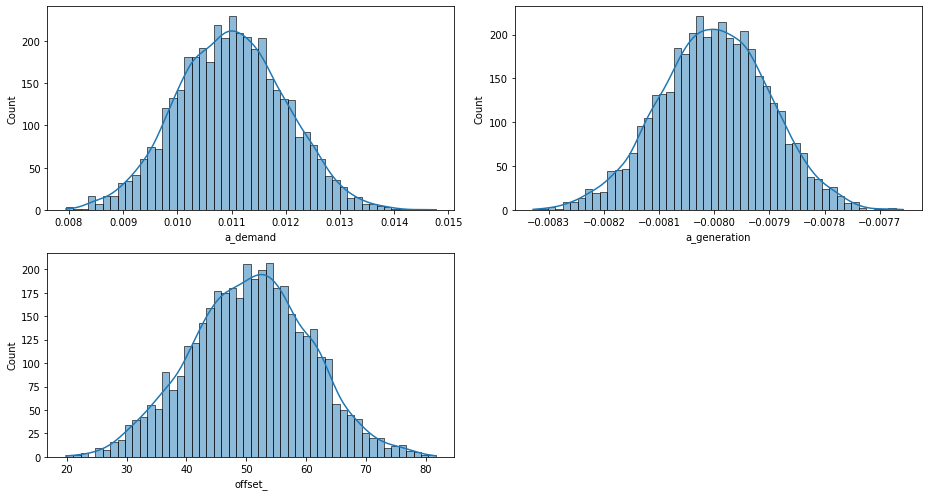

In [23]:
print(prices.summary())
parameters = ["a_demand", "a_generation", "offset_"]
N = len(parameters)
plt.figure(figsize=(13, 7))
for i in range(N):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_prices[parameters[i]], bins=50, kde=True)
plt.tight_layout()
plt.show()

### Posterior

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing csv files: /tmp/tmp8ussj4k9/prices_posterior-20230711120831_1.csv, /tmp/tmp8ussj4k9/prices_posterior-20230711120831_2.csv, /tmp/tmp8ussj4k9/prices_posterior-20230711120831_3.csv, /tmp/tmp8ussj4k9/prices_posterior-20230711120831_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



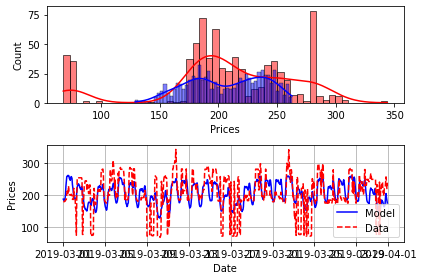

RMSE = 48.1177967986984 / (max possible) 214.47741087247994


In [24]:
y_true = data["Prices"]
prices_posterior=CmdStanModel(stan_file='prices_posterior.stan')
prices_post = prices_posterior.sample(show_progress=False, data=dict(
    N=len(data), demand=data["Krajowe zapotrzebowanie na moc"], generation=data["Sumaryczna generacja nJWCD"], prices_samples=y_true.values
    ))
print(prices_post.diagnose())
df_prices_post = prices_post.draws_pd()
df_prices_post_mean = df_prices_post.mean()[[f"prices[{i}]" for i in range(1, len(data) + 1)]]

ax = plt.subplot(2, 1, 1)
sns.histplot(y_true, kde=True, ax=ax, bins=50, color="r")
plt.xlabel("Prices")
sns.histplot(df_prices_post_mean, kde=True, ax=ax, bins=50, color="b")
plt.xlabel("Prices")
ax = plt.subplot(2, 1, 2)
ax.plot(data["Data_i_Godzina"], df_prices_post_mean, "b-",
        data["Data_i_Godzina"], y_true, "r--",)
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, df_prices_post_mean.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')

## Overall posterior

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing csv files: /tmp/tmp8ussj4k9/final_posterior-20230711130359_1.csv, /tmp/tmp8ussj4k9/final_posterior-20230711130359_2.csv, /tmp/tmp8ussj4k9/final_posterior-20230711130359_3.csv, /tmp/tmp8ussj4k9/final_posterior-20230711130359_4.csv

Checking sampler transitions treedepth.
3000 of 4000 (75.00%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

The following parameters had fewer than 0.001 effective draws per transition:
  demand_samples[25], demand_samples[26], demand_samples[193], demand_samples[194], demand_samples[361], demand_samples[362], demand_samples[529], demand_samples[530], demand_samples[697], demand_samples[698], demand[25], demand[26], deman

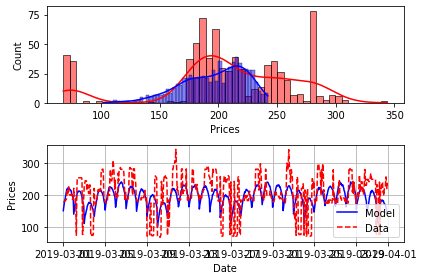

RMSE = 53.8625091340916 / (max possible) 214.47741087247994


In [27]:
data = df_zapotrzebowanie[["Godzina", "Data_i_Godzina", "Dzień tygodnia"]]
data.insert(len(data.columns), "Irradiance", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["G(i)"].values[0], 0) for i in range(len(data))
    ])
data.insert(len(data.columns), "Wind speed", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["WS10m"].values[0], 2) for i in range(len(data))
    ])
data.insert(len(data.columns), "Prices", [
    df_ceny.loc[df_ceny["Data_i_Godzina"] == data.iloc[i]["Data_i_Godzina"]]["CRO"].values[0] for i in range(len(data))
    ])
y_true = data["Prices"]
final_posterior=CmdStanModel(stan_file='final_posterior.stan')
predictions = final_posterior.sample(show_progress=False, data=dict(
    N_samples=len(data), day_of_week_historic=data["Dzień tygodnia"], hour_historic=data["Godzina"], wind_speed_historic=data["Wind speed"], 
    irradiance_historic=data["Irradiance"], prices_samples=data["Prices"],
    N=len(data), day_of_week=data["Dzień tygodnia"], hour=data["Godzina"], wind_speed=data["Wind speed"], irradiance=data["Irradiance"]
    ))
print(predictions.diagnose())
df_predictions = predictions.draws_pd()
y_pred = df_predictions.mean()[[f"prices[{i}]" for i in range(1, len(data) + 1)]]

ax = plt.subplot(2, 1, 1)
sns.histplot(y_true, kde=True, ax=ax, bins=50, color="r")
plt.xlabel("Prices")
sns.histplot(y_pred, kde=True, ax=ax, bins=50, color="b")
plt.xlabel("Prices")
ax = plt.subplot(2, 1, 2)
ax.plot(data["Data_i_Godzina"], y_pred, "b-",
        data["Data_i_Godzina"], y_true, "r--",)
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, y_pred.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')